In [100]:
from collections import Counter
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import pprint as pp
import psycopg2
from psycopg2.extras import RealDictCursor
import os
import regex as re
import spacy
import textacy
from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()
import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4), 
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

from dotenv import load_dotenv

load_dotenv()

[nltk_data] Downloading package stopwords to /Users/sf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
conn = psycopg2.connect(os.getenv('LOCAL_DB_CONN_URL'))
cur = conn.cursor(cursor_factory=RealDictCursor)

# channel_query = """
# SELECT author, content, created_timestamp, discord_message_id 
# FROM legacy_chatlogs
# WHERE discord_channel_id = '943943469821476944'
# ORDER BY created_timestamp
# """

channel_query = """
SELECT author, content, created_timestamp, discord_message_id, discord_channel_id 
FROM legacy_chatlogs
"""

cur.execute(channel_query)


In [113]:
df = pd.DataFrame(cur.fetchall())


In [114]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

Strip all emojis and discord emoticons from content

In [116]:
EMOJI_PATTERN = re.compile(
    "(["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "])"
)

EMOTICON_PATTERN = re.compile("<a:[^:]+:\d+>")

url_regex_string = r"(?:https?://|www\.)[^\s]+"
url_regex = re.compile(url_regex_string)


def strip_emojis(text):
    # Remove all Unicode emojis from the text
    text = EMOJI_PATTERN.sub(r'', text)
    return EMOTICON_PATTERN.sub(r'', text)

def replace_empty_strings(text):
    # Replace empty strings with NaN
    if text == "":
        return np.nan
    else:
        return text
    
stopwords = set(nltk.corpus.stopwords.words('english'))

include_stopwords = {'gm', 'lol', 'np', 'ty'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

def clean(text):
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # replace URLs empty string
    text = re.sub(url_regex, '', text)
    return text.strip()

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def clean_urls(text):
    # Strip entire URL unless the URL countains the literal string *Noun* or *Nouns*
    return re.sub(r'https?://[^\s]*Noun[s]?\b', 'NOUNURL', text)
    

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [117]:
#pipeline = [str.lower, strip_emojis, replace_empty_strings, tokenize, remove_stop]
pipeline = [str.lower, strip_emojis, clean, tokenize, remove_stop]


df['tokens'] = df['content'].progress_apply(prepare, pipeline=pipeline)
df['num_tokens'] = df['tokens'].progress_map(len)

# Drop any rows with NaN values in the "clean_content" column
#df.dropna(subset=['clean_content'], inplace=True)
df.drop(df[df['num_tokens'] == 0].index, inplace=True)

  0%|          | 0/148304 [00:00<?, ?it/s]

  0%|          | 0/148304 [00:00<?, ?it/s]

In [118]:

count_words(df, column='content', preprocess=url_regex.findall, min_freq=2).head(50)

  0%|          | 0/131045 [00:00<?, ?it/s]

,freq
token,
https://opensea.io/collection/voxelnouns,73
https://nouns.wtf/,42
https://nouns.center/projects,37
https://nouns.center/assets,37
https://nouns.wtf/vote,33
https://nouns.wtf,33
https://discourse.nouns.wtf/,27
https://nouns.notion.site/Explore-Nouns-a2a9dceeb1d54e10b9cbf3f931c2266f,25
https://nouns.center/traits,22


In [120]:
print(df.groupby('discord_channel_id').size().sort_values(ascending=False).head(5))

discord_channel_id
855538581434007635    65623
943943469821476944     8457
872620295507312640     7415
873197966373052426     7271
877215225093451776     6112
dtype: int64


### Token Frequency

In [ ]:
freq_df = count_words(df, column='tokens', min_freq=2)
freq_df.head(5)

In [ ]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# IDF

In [ ]:
idf_df = compute_idf(df)
idf_df.sample(5)

In [123]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [126]:
from wordcloud import WordCloud 
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [ ]:
freq_1 = count_words(df[df['discord_channel_id'] == '943943469821476944'])
freq_2 = count_words(df[df['discord_channel_id'] == '872620295507312640'])

freq_1['tfidf'] = freq_1['freq'] * idf_df['idf']
freq_2['tfidf'] = freq_2['freq'] * idf_df['idf']


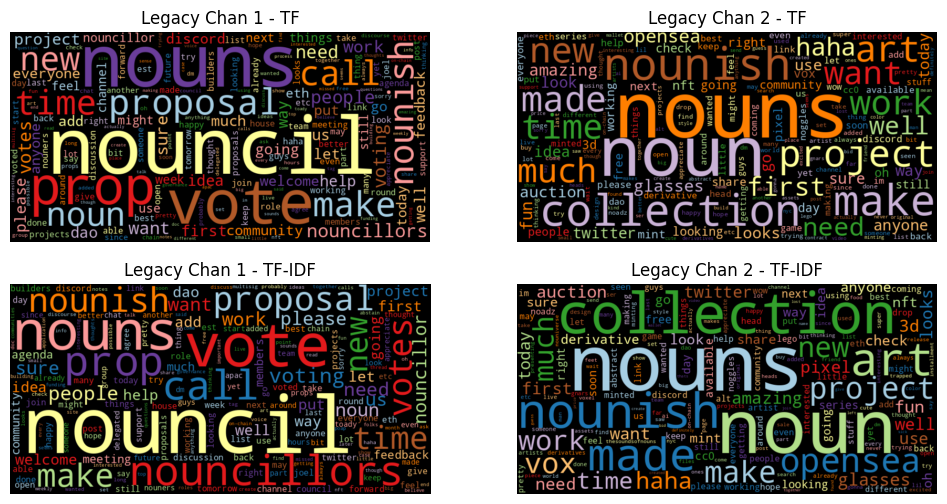

In [132]:
cloud_stop_words = {'like', 'thanks', 'could', 'also', 'would', 'really', 'something', 'awesome', 'get', 'know', 'cool',
                    'good', 'great', 'nice', 'love', 'think', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                    'got', 'thank', 'yeah', 'yes', 'no', 'maybe', 'ok', 'okay', 'hi', 'hello', 'hey', 'bye', 'goodbye', 'see', 'you', 'your', 'yours'}
plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1['freq'], title='Legacy Chan 1 - TF', stopwords=cloud_stop_words)
plt.subplot(2,2,2)###
wordcloud(freq_2['freq'], title='Legacy Chan 2 - TF', stopwords=cloud_stop_words)
plt.subplot(2,2,3)###
wordcloud(freq_1['tfidf'], title='Legacy Chan 1 - TF-IDF', stopwords=cloud_stop_words)
plt.subplot(2,2,4)###
wordcloud(freq_2['tfidf'], title='Legacy Chan 2 - TF-IDF', stopwords=cloud_stop_words)

In [ ]:
with open('output.txt', 'w') as f:
    for idx, row in df.iterrows():
        author = row['author'].split('#')[0].strip()
        date = row['created_timestamp'].strftime('%-m/%-d@%-H:%M')
        # Strip whitespace from beginning and end of "clean_content" column
        clean_content = row['clean_content'].strip()
        # Format the row as <Index>. <timestamp> <author>: <content>
        #line = f"{idx}. {row['created_timestamp']} {row['author']}: {clean_content}"
        line = f"{idx}. {date} {author}: {clean_content}"
        # Write the line to the file
        f.write(line + '\n')